In [121]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn import metrics
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
from skimage import io, transform
import os
import random
import pandas as pd
import scipy.stats as st

SMALL_SIZE = 22
MEDIUM_SIZE = 26
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=5)

Area under curve score:  0.8870588749999999


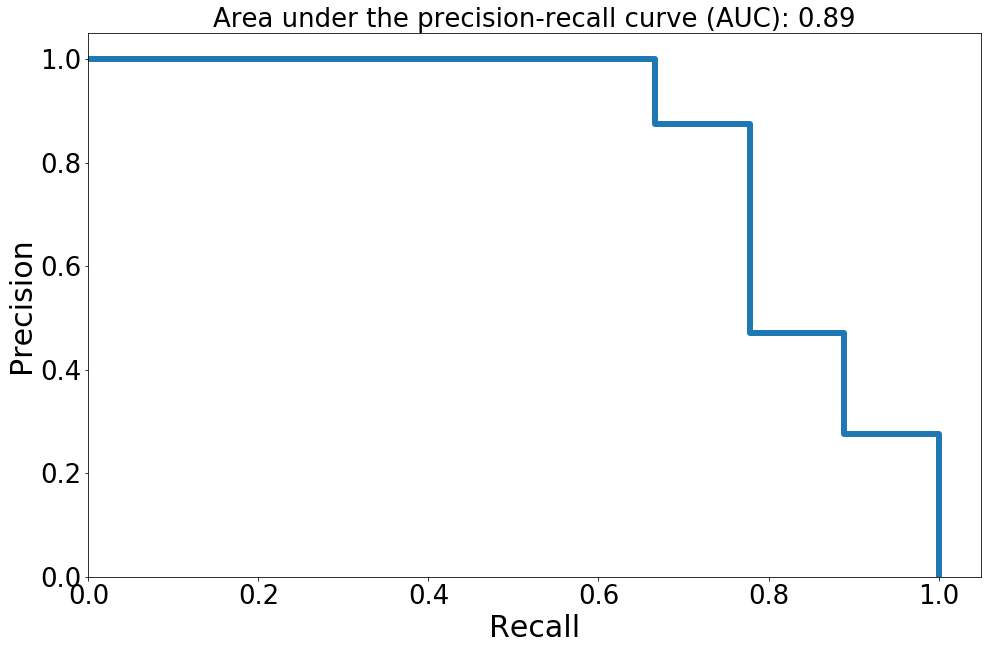

In [122]:
# Create Precision-recall curve from raw data
precision = [1., 1., 1., 1., 1., 1., 1., 0.875, 0.470, 0.275, 0.0]
recall = [0.0, 0.111, 0.222, 0.333, 0.444, 0.556, 0.667, 0.778, 0.889, 1.0, 1.00001]

def draw_pr_curve(precision, recall, path=None) -> plt.Figure:
    print('Area under curve score: ', auc(recall, precision))
    
    fig:plt.Figure = plt.figure(figsize=(16, 10))
    line:plt.Line2D = plt.step(recall, precision, linewidth=6)[0]
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title(f'Area under the precision-recall curve (AUC): {auc(recall, precision):0.2f}')
    #line.set_label('InceptionV4')
    #plt.legend(handles=[line], loc=3, fontsize=14)
    if path: plt.savefig(path)
    return fig

fig = draw_pr_curve(precision, recall, path='precision_recall_curve.png')
    

In [123]:
# Draw exaple image grid
files = os.listdir('/home/simon/Pictures/M009L')
print(files)
images = [io.imread(os.path.join('/home/simon/Pictures/M009L', f)) for f in files]
random.shuffle(images)

fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, images[:4]):
    # Iterating over the grid returns the Axes.
    im = transform.resize(im, (800, 800))
    ax.imshow(im)

plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/home/simon/Pictures/M009L'

Number of attention weights: 3911, Number of Batches: 63


Text(0.5, 1.0, 'Histogram of attention weights')

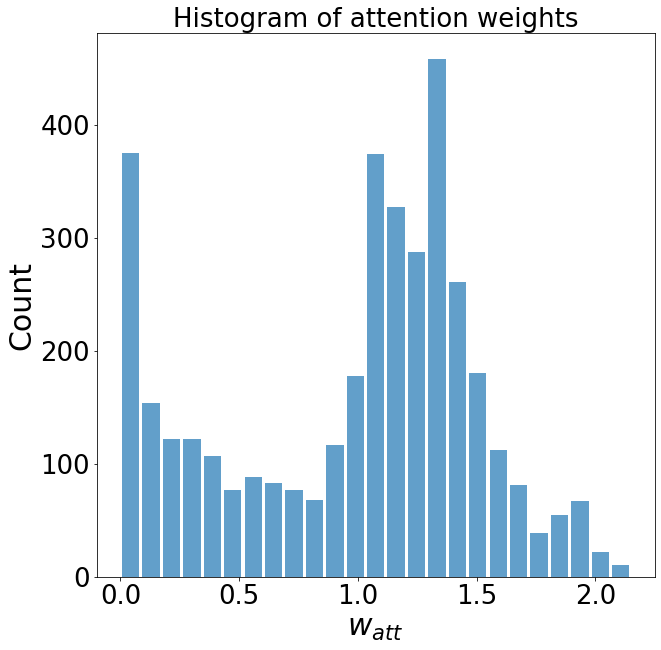

In [138]:
# Histogram of attention weights

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

df_att = pd.read_csv('../../docs/training_mil_avg_0.714_0.75.csv')
acc_attention_weights = []
for row in df_att.itertuples():
    weights = eval(row[5])
    weights = [w * len(weights) for w in weights]
    acc_attention_weights.extend(weights)
    
    
print(f'Number of attention weights: {len(acc_attention_weights)}, Number of Batches: {len(df_att)}')
att_w = np.array(acc_attention_weights)
att_w = reject_outliers(att_w, m=2)

fig = plt.figure(figsize=(10., 10.))
plt.hist(att_w, density=False, alpha=0.7, rwidth=0.85, bins=25)
#mn, mx = plt.xlim()
#kde_xs = np.linspace(mn, mx, 301)
#kde = st.gaussian_kde(att_w)
#plt.plot(kde_xs, kde.pdf(kde_xs), label="PDF")
plt.ylabel('Count')
plt.xlabel('$w_{att}$')
plt.title("Histogram of attention weights")


ROC AUC:  0.8319856244384547


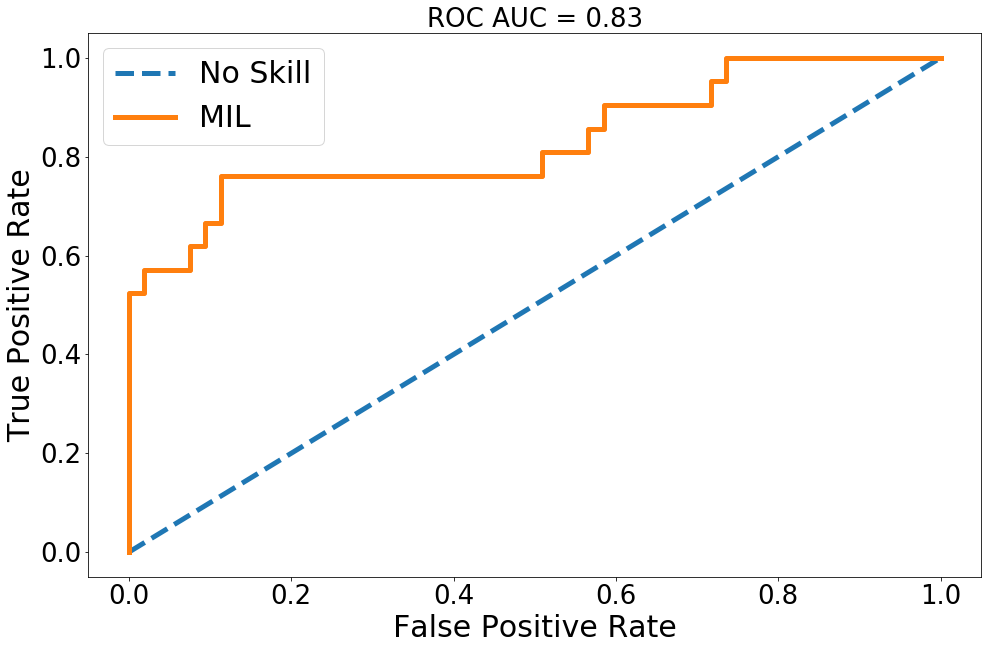

In [134]:
# calc ROC AUC

df_att = pd.read_csv('../../docs/training_mil_avg_0.744_0.700.csv')
ns_probs = [0 for _ in range(len(df_att))]
df_val = df_att.iloc[:, :4]
#df_val.head(100)

ns_auc = roc_auc_score(df_val['label'], ns_probs)
lr_auc = roc_auc_score(df_val['label'], df_val['probability'])
lr_fpr, lr_tpr, ths = roc_curve(df_val['label'], df_val['probability'])
ns_fpr, ns_tpr, _ = roc_curve(df_val['label'], ns_probs)

plt.figure(figsize=(16, 10))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='MIL')
plt.xlabel('False Positive Rate') # axis labels
plt.ylabel('True Positive Rate')
plt.title(f'ROC AUC = {lr_auc:0.2f}')
plt.legend() # show the legend

print('ROC AUC: ', lr_auc)

Precision recall AUC:  0.7923573250444833


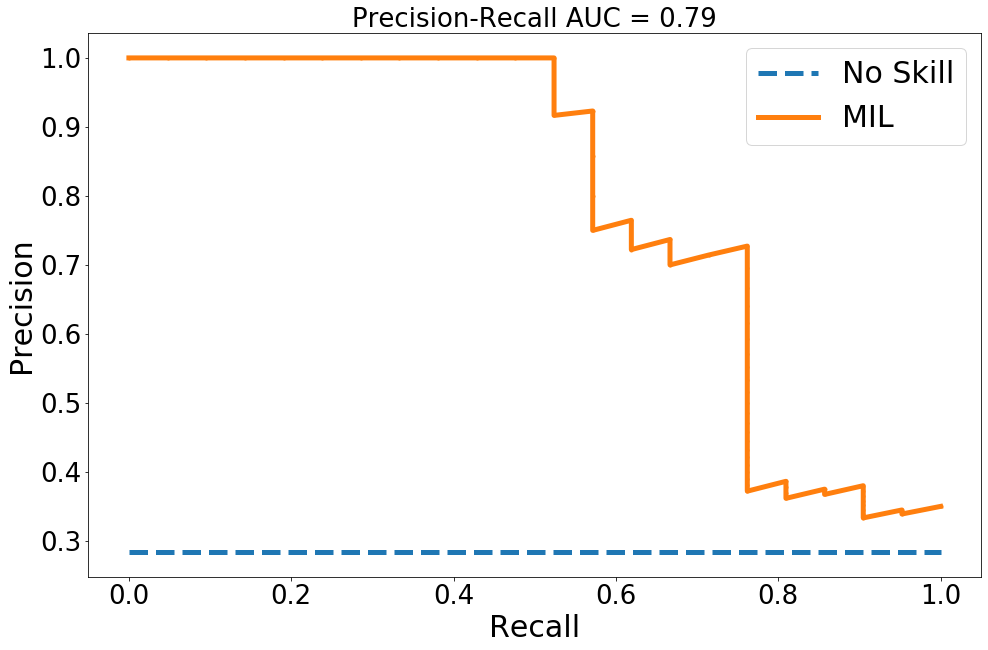

In [130]:
# Precision-recal curve
precision, recall, ths = precision_recall_curve(df_val['label'], df_val['probability'])
pr_auc = metrics.auc(recall, precision)
no_skill = len(df_val['label'][df_val['label']==1]) / len(df_val['label'])

plt.figure(figsize=(16, 10))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='MIL')

plt.xlabel('Recall') # axis labels
plt.ylabel('Precision')
plt.title(f'Precision-Recall AUC = {pr_auc:0.2f}')
plt.legend() # show the legend

print('Precision recall AUC: ', pr_auc)